# **Quantum Machine Learning with TensorFlow Quantum & Cirq**

## In this project, we perform the Binary Image Classification on Fashion MNIST dataset with TensorFlow Quantum and Cirq

We will be implementing binary classification on the labels - Sandal and Ankle Boot for the Fashion mnist dataset in grayscale (values ranging from 0 to 255)

### Import Required Packages

In [1]:
# !pip install cirq
# !pip install tensorflow==2.16.2 tensorflow-quantum==0.7.5
# !pip install sympy

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [3]:
import tensorflow as tf

import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow_quantum as tfq
import cirq
import sympy

from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

'''Ignore warnings'''
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Import Dataset

In [4]:
from tensorflow.keras.datasets import fashion_mnist as dataset
(X_train, y_train), (X_test, y_test) = dataset.load_data()

### Data Pre-Processing

In [5]:
print("Shape of X_train is : {}".format(X_train.shape))
print("Shape of y_train is : {}".format(y_train.shape))
print("Shape of X_test is : {}".format(X_test.shape))
print("Shape of y_test is : {}".format(y_test.shape))

Shape of X_train is : (60000, 28, 28)
Shape of y_train is : (60000,)
Shape of X_test is : (10000, 28, 28)
Shape of y_test is : (10000,)


In [6]:
def filter_data(x,y):
  """
  Helper function for filtering the dataset for 2 labels only
  """
  keep = (y==5) | (y==9)  # Sandal - 5, Ankle Boot - 9
  x, y = x[keep], y[keep]
  y = y==5
  return x,y

In [7]:
# Fliter the train, test splits.
X_train, y_train = filter_data(X_train,y_train)
X_test, y_test = filter_data(X_test,y_test)

In [8]:
print("Shape of X_train is : {}".format(X_train.shape))
print("Shape of y_train is : {}".format(y_train.shape))
print("Shape of X_test is : {}".format(X_test.shape))
print("Shape of y_test is : {}".format(y_test.shape))

Shape of X_train is : (12000, 28, 28)
Shape of y_train is : (12000,)
Shape of X_test is : (2000, 28, 28)
Shape of y_test is : (2000,)


The first image in the dataset has the label False


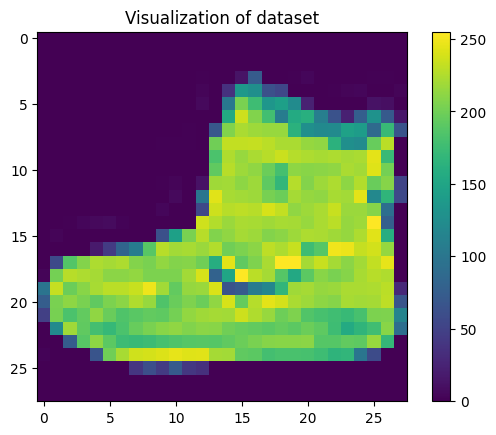

In [9]:
# Let's look at the first image in the dataset
print("The first image in the dataset has the label {}".format(y_train[0]))
plt.imshow(X_train[0])
plt.colorbar()
plt.title("Visualization of dataset")
plt.show()

In [10]:
# normalizing the test and train datasets
# to have values between 0 and 1 instead of the
# grayscale values ranging from 0 to 255

X_train = X_train/255.0
X_test = X_test/255.0

The first image in the dataset has the label False


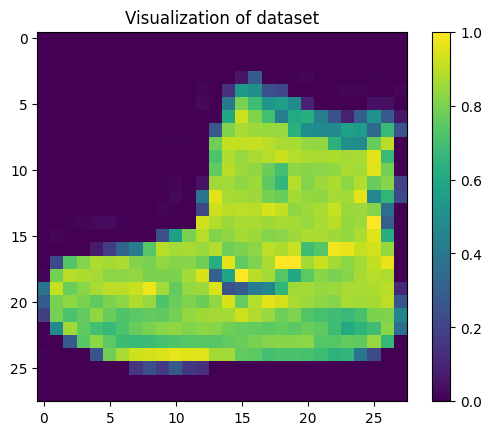

In [11]:
# Let's look at the first image in the dataset post normalization
print("The first image in the dataset has the label {}".format(y_train[0]))
plt.imshow(X_train[0])
plt.colorbar()
plt.title("Visualization of dataset")
plt.show()

In [12]:
# We need to reshape the images in our dataset
X_train = X_train.reshape(X_train.shape[0],*(28,28,1))
X_test = X_test.reshape(X_test.shape[0],*(28,28,1))

In [13]:
# Downscaling the images
X_train = tf.image.resize(X_train, (2,2)).numpy()
X_test = tf.image.resize(X_test, (2,2)).numpy()

The image in the dataset has the label False


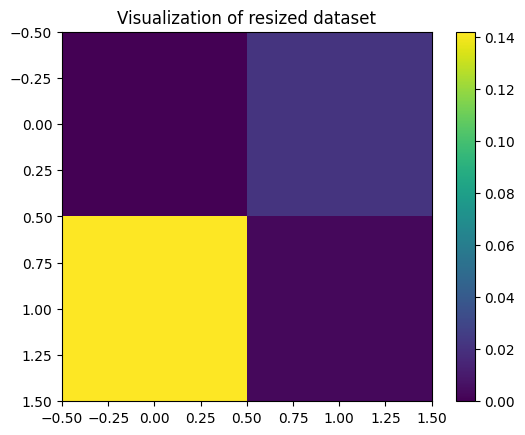

In [14]:
# Let's look at the image in the dataset again
print("The image in the dataset has the label {}".format(y_train[0]))
plt.imshow(X_train[1,:,:,0])
plt.colorbar()
plt.title("Visualization of resized dataset")
plt.show()

In [15]:
# Splitting the dataset into train and validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=0)

In [16]:
print("Shape of X_train is : {}".format(X_train.shape))
print("Shape of y_train is : {}".format(y_train.shape))
print("Shape of X_valid is : {}".format(X_valid.shape))
print("Shape of y_valid is : {}".format(y_valid.shape))

Shape of X_train is : (10200, 2, 2, 1)
Shape of y_train is : (10200,)
Shape of X_valid is : (1800, 2, 2, 1)
Shape of y_valid is : (1800,)


### Data Encoding

We need to


*   Process pixel values for binary encoding
*   Converting Cirq Circuits to tfq tensors



**Step 1: Processing pixel values for Binary Encoding**

In [17]:
#Flatenning the images
X_train = X_train.reshape(X_train.shape[0],*(1,4,1))
X_valid = X_valid.reshape(X_valid.shape[0],*(1,4,1))
X_test = X_test.reshape(X_test.shape[0],*(1,4,1))

In [18]:
print(X_train[1])

[[[0.        ]
  [0.90588236]
  [0.7882353 ]
  [0.8686274 ]]]


In [19]:
def binary_encode(X, threshold = 0.5):
  """
  Encodes the given dataset to use binary encoding

  Parameters:
  X(array) : Image data to be processed for encoding
  threshold(float) : Threshold for binary encoding, 0.5 by default

  Returns:
  encoded_images(array): Binary encoded Image Data
  """

  encoded_images = list()
  for image in X:
    encoded_image = [1 if j>threshold else 0 for j in image[0]]
    encoded_images.append(encoded_image)
  return np.array(encoded_images)


In [20]:
X_train = binary_encode(X_train)

In [21]:
print(X_train[1])

[0 1 1 1]


In [22]:
print("Shape of the X_train dataset is {}".format(X_train.shape))

Shape of the X_train dataset is (10200, 4)


In [23]:
def create_circuit_from_img(encoded_image):
  '''
  Returns a circuit for the given encoded image

  Parameters:
  encoded_image (array): Encoded Image

  Returns:
  circuit (cirq.Circuit object): Cirq circuit for the given image
  '''
  qubits = cirq.GridQubit.rect(2, 2)
  Circuit = cirq.Circuit()
  for i,pixel in enumerate(encoded_image):
    if pixel:
      Circuit.append(cirq.X(qubits[i]))
  return Circuit

In [24]:
X_train = [create_circuit_from_img(encoded_image) for encoded_image in X_train]

In [25]:
X_train[0]

(1, 0): ───X───

(1, 1): ───X───

Values for the first image were 0,0,1,1. This implies that we should apply X or NOT gate for the last two qubits since all qubits are initially in the 0 states.


Step 2: Converting the Cirq Circuits to tfq Tensors

In [26]:
X_train_tfq = tfq.convert_to_tensor(X_train)

**Processing X_valid and X_test**

In [27]:
X_valid = binary_encode(X_valid)
X_test = binary_encode(X_test)

In [28]:
X_valid = [create_circuit_from_img(encoded_image) for encoded_image in X_valid]
X_test = [create_circuit_from_img(encoded_image) for encoded_image in X_test]

In [29]:
X_valid_tfq = tfq.convert_to_tensor(X_valid)
X_test_tfq = tfq.convert_to_tensor(X_test)

### Quantum Neural Network

**Build the QNN:**


1.   Build a class that adds gates layer by layer
2.   Define the QNN using the class from the above step



In [30]:
class QNN():
  def __init__(self, data_qubits, readout):
    self.data_qubits = data_qubits
    self.readout = readout

  def add_singleQubit_gate(self, circuit, gate, qubit_index):
    '''
    Adds single qubit gate tot he circuit

    Parameters:
    circuit (cirq.Circuit object): Cirq Circuit
    gate(cirq gate): gate to append to the circuit
    qubit_index(list): index of qubits to apply the gate

    Returns:
    None
    '''

    for index in qubit_index:
      circuit.append(gate(self.data_qubits[index]))
  def add_twoQubit_gate(self, circuit, gate, qubit_index):
    '''
    Adds two qubit gate to the circuit

    Parameters:
    circuit (cirq.Circuit object): Cirq Circuit
    gate(cirq gate): gate to append to the circuit
    qubit_index(list): index of qubits to apply the gate

    Returns:
    None
    '''

    if len(qubit_index)!=2:
      raise Exception("The length of list of two qubit should be 2")
    circuit.append(gate(self.data_qubits[qubit_index[0]], self.data_qubits[qubit_index[1]]))

  def add_layer(self, circuit, gate, symbol_gate):
    '''
    Adds a new layer to the circuit

    Parameters:
    circuit (cirq.Circuit object): Cirq Circuit
    gate(cirq gate): gate to append to the circuit
    symbol_gate(string): Symbol for the gate

    Returns:
    None
    '''

    for i,qubit in enumerate(self.data_qubits):
      symbol = sympy.Symbol(symbol_gate + '-' + str(i))
      circuit.append(gate(qubit, self.readout)**symbol)


In [31]:
def create_qnn():
  '''
  Create a QNN model circuit and a readout circuit to go along with it
  '''

  data_qubits = cirq.GridQubit.rect(2, 2)
  readout = cirq.GridQubit(-1,-1)           # a single qubit at [-1,-1]
  circuit = cirq.Circuit()

  # Prepare the readout qubit
  circuit.append(cirq.X(readout))
  circuit.append(cirq.H(readout))

  qnn = QNN(data_qubits = data_qubits, readout = readout)
  qnn.add_layer(circuit, cirq.XX, 'XX')

  # We don't use single and double qubit gates in this circuit
  # but we can add them using "add_singleQubit_gate" and "add_twoQubit_gate"
  # respectively.

  # Add the ising coupling XX gate
  qnn.add_layer(circuit, cirq.XX, 'XX')
  qnn.add_layer(circuit, cirq.ZZ, 'ZZ')

  # Now prepare the readout qubit
  circuit.append(cirq.H(readout))

  return circuit, cirq.Z(readout)

In [32]:
qmodel, model_readout = create_qnn()

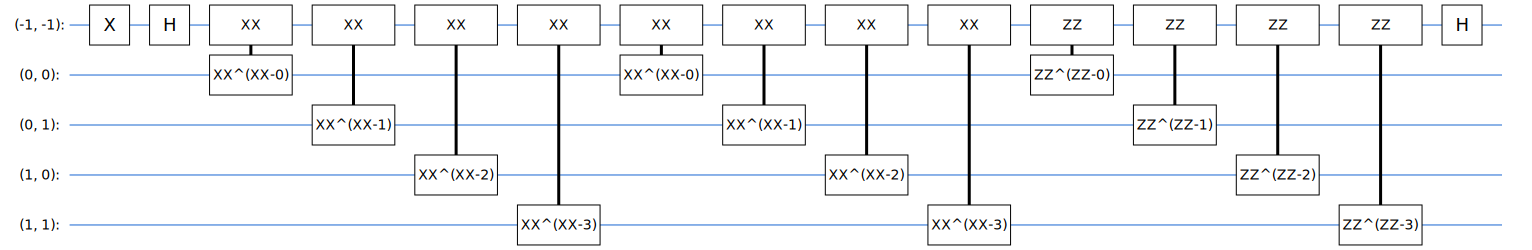

In [33]:
# To display the quantum circuit that will perform the classification
SVGCircuit(qmodel)

In [34]:
model = tf.keras.Sequential([
    # the input is the data circuit encoded as a tf.string

    tf.keras.layers.Input(shape=(), dtype=tf.string),

    # PQC - Parameterized Quantum Circuit
    # This will return the expectation value
    tfq.layers.PQC(qmodel, model_readout),
])


In [35]:
# In order to use Hinge Loss, we convert the labels to 1 and -1
y_train_h = np.array([1 if i==1 else -1 for i in y_train])
y_valid_h = np.array([1 if i==1 else -1 for i in y_valid])
y_test_h = np.array([1 if i==1 else -1 for i in y_test])

In [36]:
# This is the first label from the training set
print(y_train_h[0])

1


In [37]:
# Defining the custom Hinge accuracy
def hinge_accuracy(y_true, y_pred):
  y_true = tf.squeeze(y_true) > 0.0
  y_pred = tf.squeeze(y_pred) > 0.0
  result = tf.cast(y_true == y_pred, tf.float32)

  return tf.reduce_mean(result)

**Train the QNN**

In [38]:
model.compile(
    loss = tf.keras.losses.Hinge(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = [hinge_accuracy])

In [39]:
qnn_history = model.fit(
      X_train_tfq, y_train_h,
      batch_size=64,
      epochs=10,
      verbose=1,
      validation_data=(X_valid_tfq, y_valid_h))

Epoch 1/10
160/160 [==============================] - 17s 33ms/step - loss: 0.8914 - hinge_accuracy: 0.6507 - val_loss: 0.6309 - val_hinge_accuracy: 0.7845
Epoch 2/10
160/160 [==============================] - 5s 29ms/step - loss: 0.4911 - hinge_accuracy: 0.8013 - val_loss: 0.4067 - val_hinge_accuracy: 0.8292
Epoch 3/10
160/160 [==============================] - 6s 37ms/step - loss: 0.4092 - hinge_accuracy: 0.8233 - val_loss: 0.3893 - val_hinge_accuracy: 0.8351
Epoch 4/10
160/160 [==============================] - 5s 29ms/step - loss: 0.3982 - hinge_accuracy: 0.8347 - val_loss: 0.3909 - val_hinge_accuracy: 0.8351
Epoch 5/10
160/160 [==============================] - 6s 36ms/step - loss: 0.3952 - hinge_accuracy: 0.8345 - val_loss: 0.3929 - val_hinge_accuracy: 0.8351
Epoch 6/10
160/160 [==============================] - 5s 29ms/step - loss: 0.3939 - hinge_accuracy: 0.8084 - val_loss: 0.3940 - val_hinge_accuracy: 0.7958
Epoch 7/10
160/160 [==============================] - 5s 29ms/step - 

In [40]:
model.evaluate(X_test_tfq, y_test_h)

63/63 [==============================] - 1s 9ms/step - loss: 0.3703 - hinge_accuracy: 0.8229


[0.3702976405620575, 0.8229166865348816]

### Visualizing the Results

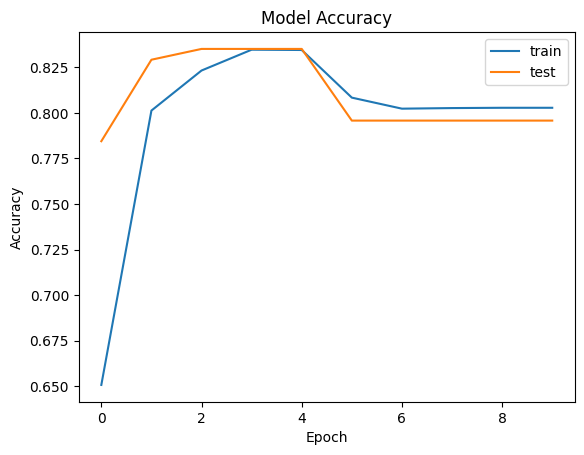

In [41]:
# Visual Accuracy
plt.plot(qnn_history.history['hinge_accuracy'])
plt.plot(qnn_history.history['val_hinge_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='best')
plt.show()

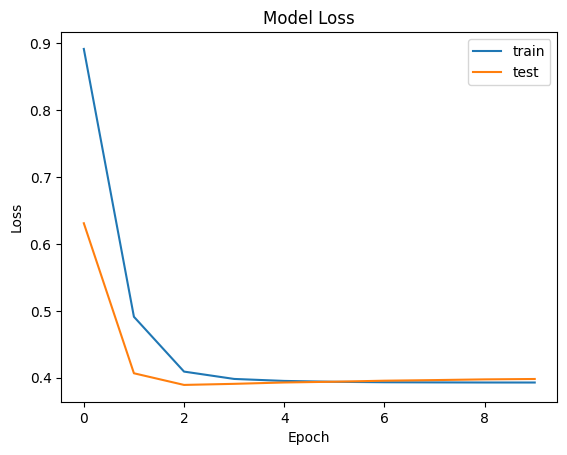

In [42]:
# Visual Loss
plt.plot(qnn_history.history['loss'])
plt.plot(qnn_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='best')
plt.show()

### Save the Model Weights

In [43]:
# Saving the weights
model.save_weights('/content/sample_data/QModelWeights')

### References:



* https://www.tensorflow.org/quantum/tutorials/mnist
* https://quantumai.google/cirq/tutorials
* Paper by Farhi et al - https://arxiv.org/pdf/1802.06002.pdf
